# Unit Testing Optimisation

## Importing the Packages

In [7]:
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams.update(mpl.rcParamsDefault)
mpl.use("pgf")
%matplotlib inline
plt.plot([1, 2, 3])
mpl.use("pgf")
mpl.rcParams.update(
    {
        "pgf.texsystem": "lualatex",
        "font.family": "serif",
        "text.usetex": True,
        "pgf.rcfonts": False,
        "pgf.preamble": "\n".join(
            [
                r"\usepackage{bm}",
                r"\usepackage{mathtools}",
                r"\usepackage{amsmath}",
                r"\DeclarePairedDelimiter\abs{\lvert}{\rvert}%",
                r"\DeclarePairedDelimiter\norm{\lVert}{\rVert}",
                r"\makeatletter",
                r"\let\oldabs\abs",
                r"\def\abs{\@ifstar{\oldabs}{\oldabs*}}",
                r"\let\oldnorm\norm",
                r"\def\norm{\@ifstar{\oldnorm}{\oldnorm*}}",
                r"\makeatother",
                r"\usepackage[dvipsnames]{xcolor}", 
                r"\definecolor{myred}{RGB}{205, 108, 46}",
            ]
        ),
        "font.serif": ["Computer Modern Roman"],
    }
)

import matplotlib.font_manager
import matplotlib.ticker as mticker
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import Divider, Size, make_axes_locatable
import matplotlib.patches as mpatches
from mpl_toolkits import mplot3d
import matplotlib.cm as cm

import numpy as np
import pandas as pd
import scipy as sc
import scipy.io as io
from scipy.stats import multivariate_normal
from functools import partial

import jax.numpy as jnp
import jax.scipy as jsc
from jax import grad, jit, vmap, random, lax, value_and_grad, tree_multimap, tree_map

import time

In [8]:
from jax.config import config
config.update("jax_enable_x64", True)
config.update("jax_debug_nans", True)

## Defining SE Covariance

In [9]:
@jit
def AlpEnvelope(Xarr, TRise, TauDiff, Lag):
  TRise = TRise ** 2.0
  TDecay = TRise + TauDiff ** 2 + 1e-8
  TMax = (jnp.log(TRise / TDecay) * TDecay * TRise) / (TRise - TDecay)
  Max =  jnp.exp(- TMax / TDecay) - jnp.exp(- TMax / TRise)
  Delayed = Xarr - Lag
  NewTime = jnp.where(Delayed < 0.0, 1000, Delayed)
  return (jnp.exp(- NewTime / TDecay) - jnp.exp(- NewTime / TRise)) / Max

In [10]:
@jit
def Squared_exp(I, J, Sigma_f, Ell):
  return Sigma_f**2.0*jnp.exp(-(I-J)**2/(2.0*Ell**2))

## Obtaining Training Data

In [11]:
key = random.PRNGKey(1)
key, *subkeys = random.split(key, 4)

### Importing Spike Trains and Finger Movement

In [14]:
data = pd.read_hdf('./Data/finger_posdata.h5')
k = 6000
num_filt = 130
xtest = data.spikes.to_numpy()[:k, :num_filt]
data.index = data.index - data.index[0]
ytime = (data.index / np.timedelta64(1, 's')).to_numpy()[:k]
ycoord = data.finger_pos.y.to_numpy()[:k]
xcoord = data.finger_pos.x.to_numpy()[:k]
k, num_filt = np.shape(xtest)
k -= 1
ytest = ycoord.reshape(k + 1, 1)
xtest = xtest.T[:,:,None]
data.spikes
del data
xtest = jnp.asarray(xtest)
ytest = jnp.asarray(ytest)
print(xtest.shape)

TypeError: cannot perform __sub__ with this index type: MultiIndex

: 

### Removing Bias from Finger Coordinates

In [ ]:
print(xtest.shape)
print((xtest[:, 0, :] == 1.0).any())

(130, 6000, 1)
False


In [ ]:
print(ytest.shape)

(6000, 1)


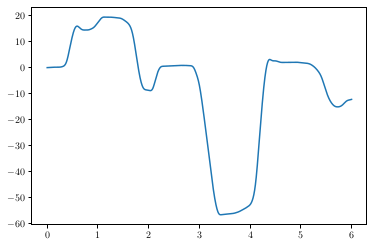

In [ ]:
ytest -= ytest[0, 0]
plt.plot(ytime, ytest)

### Setting up Filter Sizes

In [ ]:
subkeyf = subkeys[-2]

# Time bin size
time_bin = ytime[1] - ytime[0]
print(time_bin)
# Filter horizon
f_maxt = 1.0

# Maximum index of filter data
n = np.floor(f_maxt/time_bin).astype(np.int64)
ftime = np.linspace(0.0, f_maxt, n + 1).reshape((n + 1, 1))

0.001


In [ ]:
xpad = np.hstack((xtest, np.zeros((num_filt, n, 1))))
x_fft = np.fft.rfft(xpad, axis=1)
print(x_fft)
print(x_fft.shape)
print(xtest.shape)
print(ytest.shape)
print(ftime.shape)

[[[ 17.        +0.j        ]
  [ -0.39716034-5.05795313j]
  [ -0.77656255-2.46462736j]
  ...
  [ -1.43586824+1.69721229j]
  [  0.39595999-1.75501657j]
  [ -5.        +0.j        ]]

 [[ 64.        +0.j        ]
  [-11.69466985-4.42131678j]
  [  7.10939987-8.07330345j]
  ...
  [  4.11553349+6.51202137j]
  [  6.75159384-0.37713681j]
  [-14.        +0.j        ]]

 [[ 23.        +0.j        ]
  [ -2.63833462-4.7525739j ]
  [  3.771608  -5.3973448j ]
  ...
  [ -4.8257393 +2.83803488j]
  [ -3.53325633+3.98752197j]
  [  5.        +0.j        ]]

 ...

 [[ 14.        +0.j        ]
  [ -0.56625207+4.36772429j]
  [ -4.40300958-2.1288982j ]
  ...
  [ -0.72537992+1.10603376j]
  [ -2.18063126-3.65543076j]
  [  6.        +0.j        ]]

 [[  6.        +0.j        ]
  [ -0.10691302-0.12848486j]
  [  2.16512272+0.69722558j]
  ...
  [ -0.51518008-3.23236834j]
  [ -0.39841457+0.86088959j]
  [  2.        +0.j        ]]

 [[  1.        +0.j        ]
  [ -0.81269416-0.58269048j]
  [  0.32094361+0.9470983j

## Variational Inference

### ELBO

#### Kl Divergence Term

In [ ]:
@jit
def KL_Term(L_Matrix, V_Vector, Num_Filt, M):
  return  0.5 * (- jnp.sum(jnp.log(jnp.diagonal(L_Matrix, axis1 = 1, axis2 = 2) ** 2)) + \
                jnp.sum(L_Matrix ** 2) + jnp.sum(V_Vector ** 2) - Num_Filt * M)

In [ ]:
test_key = random.PRNGKey(0)
test_m = 20
test_l_mm = random.uniform(test_key, (num_filt, test_m, test_m))
test_v_m = random.uniform(test_key, (num_filt, test_m, 1))

In [ ]:
print(KL_Term(test_l_mm, test_v_m, num_filt, test_m))

10418.547122622198


#### Expected Log-Likelihood

In [ ]:
@jit
def Solver(Kmm, Diff):
  return jsc.linalg.solve(Kmm, Diff, sym_pos=True, check_finite=True)

In [ ]:
@jit
def FFTScan(Carry, Arr):
  return Carry, jnp.fft.rfft(Arr, axis = 0)

In [ ]:
@jit
def FilLoop(Carry, Filter):
  return Carry, lax.scan(FFTScan, 0, Filter)[1]

In [ ]:
V_Solver = vmap(Solver, in_axes = [None, 0])

In [ ]:
@partial(jit, static_argnums = range(9,15))
def Expected_Term(Sigma_f, Ell, Sigma_n, Z_Vector, V_Vector, L_Matrix, TRise, TauDiff, Lag, Number_F, Num_Base, M, Number_Filt, N, K, Y_Test, X_Fft, F_Time, Subkeys):

  Sigma_f_d = Sigma_f[:, :, None]
  Ell_f_d = Ell[:, :, None]
  TRise_d = TRise[:, :, None]
  TauDiff_d = TauDiff[:, :, None]

  Thetas = random.normal(Subkeys[0], (Number_F, Number_Filt, 1, Num_Base)) * (1.0 / Ell_f_d)

  Taus = random.uniform(Subkeys[1], (Number_F, Number_Filt, 1, Num_Base)) * 2.0 * jnp.pi

  Omegas = random.normal(Subkeys[2], (Number_F, Number_Filt, Num_Base, 1))

  Constant = (Sigma_f_d * jnp.sqrt(2.0 / Num_Base))

  ZT = Z_Vector.transpose(0, 2, 1)
 
  Phi1 = Constant * jnp.cos(F_Time * Thetas + Taus)
  Phi2 = Constant * jnp.cos(Z_Vector * Thetas + Taus)

  Kmm = Squared_exp(Z_Vector, ZT, Sigma_f_d, Ell_f_d)
  Knm = Squared_exp(F_Time, ZT, Sigma_f_d, Ell_f_d)

  C = jnp.linalg.cholesky(Kmm + jnp.eye(M) * 1e-6)

  V_u = C @ L_Matrix @ L_Matrix.transpose(0, 2, 1) @ C.transpose(0, 2, 1)

  Mu_u = C @ V_Vector

  V_uChol = jnp.linalg.cholesky(V_u + 1e-6 * jnp.eye(M))

  U_Samples = Mu_u + V_uChol @ random.normal(Subkeys[3], (Number_F, Number_Filt, M, 1))

  Vu = V_Solver(Kmm + 1e-6 * jnp.eye(M), U_Samples - Phi2 @ Omegas)

  F_Samples = (Phi1 @ Omegas + Knm @ Vu) * AlpEnvelope(F_Time, TRise_d, TauDiff_d, Lag)

  F_Samples = jnp.dstack((F_Samples, jnp.zeros((Number_F, Number_Filt, K, 1))))

  F_Fft = jnp.fft.rfft(F_Samples, axis = -2)

  Filter_Out = jnp.fft.irfft(F_Fft * X_Fft, N + K + 1, axis = -2)[:, :, : K + 1]

  Pred = jnp.sum(Filter_Out, axis = 1)
  
  Likelihoods = - 0.5 * ((K + 1) * jnp.log(2 * jnp.pi * Sigma_n ** 2) + \
                    jnp.sum((Y_Test - Pred)**2, axis = 1)/(Sigma_n ** 2))
  
  return jnp.mean(Likelihoods)

In [ ]:
test_number_f = 50
test_num_base = 100
test_m = int(20)
test_key = random.PRNGKey(0)
test_key, *test_subkeys = random.split(test_key, 5)
test_sigma_f = 5.0 * np.ones((num_filt, 1))# np.arange(num_filt).reshape(1, num_filt, 1, 1)
test_ell_f = 2.0 * np.ones((num_filt, 1))
test_sigma_n = 0.05
test_z_m = np.tile(np.linspace(0.0, ftime[-1], test_m).reshape((test_m, 1)), (num_filt, 1, 1))
test_v_m = np.zeros(test_m * num_filt).reshape((num_filt, test_m, 1))
test_l_mm = np.tile(np.eye(test_m), (num_filt, 1, 1))
test_trise = 0.2 * np.ones((num_filt, 1))
test_tdiff = 0.5 * np.ones((num_filt, 1))
test_lag = 0.01 * np.ones((num_filt, 1))
test_lag = test_lag[:,:, None]
print(xtest.shape)
xtest = xtest.reshape(num_filt, k + 1, 1)
ftime = ftime.reshape(n + 1, 1)
print(xtest.shape)
print(ftime.shape)
print(x_fft.shape)

(130, 6000, 1)
(130, 6000, 1)
(1001, 1)
(130, 3501, 1)


In [ ]:
samps = Expected_Term(test_sigma_f, test_ell_f, test_sigma_n, test_z_m, test_v_m, test_l_mm, test_trise, test_tdiff, test_lag, test_number_f, test_num_base, test_m, num_filt, n, k, ytest, x_fft, ftime, test_subkeys)

In [ ]:
print(samps)

-27739827012.55772


#### ELBO

In [ ]:
Diag = jit(vmap(jnp.diag, in_axes=[0,]))

In [ ]:
@partial(jit, static_argnums = range(10, 16))
def Neg_ELBO(Sigma_f, Ell, Sigma_n, Z_Fractions, V_Vector, L_Diag, L_ODiag, TRise, TauDiff, Lag, Number_F, Num_Base,
         M, Number_Filt, N, K, Indices, Y_Test, X_Fft, F_Time, Subkeys):
         
  Lag = Lag ** 2.0

  Lag_d = Lag[:, :, None]
  
  Z_Vector = (0.5 * jnp.sin( jnp.pi * (Z_Fractions - 0.5)) + 0.5) * (F_Time[-1, 0] - Lag_d) + Lag_d

  D = Diag(jnp.exp(L_Diag))

  L_Matrix = D.at[:, Indices[0], Indices[1]].set(L_ODiag)

  KL = KL_Term(L_Matrix, V_Vector, Number_Filt, M)
  Exp = Expected_Term(Sigma_f, Ell, Sigma_n, Z_Vector, V_Vector, L_Matrix, TRise, TauDiff, Lag_d, Number_F, Num_Base,
                  M, Number_Filt, N, K, Y_Test, X_Fft, F_Time, Subkeys)
                  
  return (KL-Exp)/(Number_Filt + K + 1)

In [ ]:
test_number_f = 15
test_num_base = 100
test_m = int(20)
test_key = random.PRNGKey(0)
test_key, *test_subkeys = random.split(test_key, 5)
test_sigma_f = 2.0 * np.ones((num_filt, 1))# np.arange(num_filt).reshape(1, num_filt, 1, 1)
test_ell_f = 0.7 * np.ones((num_filt, 1))
test_sigma_n = 0.01
test_z_final = jnp.tile(jnp.linspace(0.0, 1.0, test_m).reshape((test_m, 1)), (num_filt, 1, 1))
test_z_m = (jnp.arcsin(2.0 * (test_z_final - 0.5)) / jnp.pi) + 0.5
test_v_m = 5.0 * np.ones((num_filt, test_m, 1))
test_l_diag = np.ones((num_filt, test_m))
test_l_odiag = np.tile(np.tril(np.ones((test_m, test_m)), -1)[np.tril_indices(test_m, -1)], (num_filt, 1))
test_trise = 0.02 * np.ones((num_filt, 1))
test_tdiff = 0.03 * np.ones((num_filt, 1))
test_lag = 0.01 * np.ones((num_filt, 1))
test_diagMat = Diag(test_l_diag)
test_indices = np.tril_indices(test_m, -1)
print(test_l_odiag.shape)
print(ftime.shape)

(130, 190)
(1001, 1)


In [ ]:
print(Neg_ELBO(test_sigma_f, test_ell_f, test_sigma_n, test_z_m, test_v_m, test_l_diag, test_l_odiag, test_trise, test_tdiff, test_lag, test_number_f, test_num_base, test_m, num_filt, n, k, test_indices, ytest, x_fft, ftime, test_subkeys))

4482192.067579385


In [ ]:
Grad_Bound = jit(value_and_grad(Neg_ELBO, argnums = range(10)), static_argnums = range(10, 16))

### Optimiser

#### Sub-function Definitions

In [ ]:
@jit
def MCalc(Grad, M, B1 = 0.9):
  return (1 - B1) * Grad + B1 * M

In [ ]:
@jit
def MBias(M, Step, B1 = 0.9):
  return M / (1 - B1 ** (Step + 1))

In [ ]:
@jit
def VCalc(Grad, V, B2 = 0.99):
  return (1 - B2) * jnp.square(Grad) + B2 * V

In [ ]:
@jit
def VBias(V, Step, B2 = 0.99):
  return V / (1 - B2 ** (Step + 1))

In [ ]:
@jit
def CFinState(X, Mhat, Vhat, Step_Size = 1e-2, Eps = 1e-8):
  return X - Step_Size * Mhat / (jnp.sqrt(Vhat) + Eps)

In [ ]:
@jit
def MFinState(X, Mhat, Vhat, Step_Size = 1e-3, Eps = 1e-8):
  return X - Step_Size * Mhat / (jnp.sqrt(Vhat) + Eps)

In [ ]:
@jit
def FFinState(X, Mhat, Vhat, Step_Size = 1e-4, Eps = 1e-8):
  return X - Step_Size * Mhat / (jnp.sqrt(Vhat) + Eps)

In [ ]:
@jit
def CAdam(Step, X, Grad, M, V):

  M = tree_multimap(MCalc, Grad, M) # First  moment estimate.
  V = tree_multimap(VCalc, Grad, V)  # Second moment estimate.
  Step = tuple(Step * jnp.ones(10))
  Mhat = tree_map(MBias, M, Step) # Bias correction.
  Vhat = tree_map(VBias, V, Step) # Bias correction.

  X = tree_multimap(CFinState, X, Mhat, Vhat)

  return X, M, V

In [ ]:
@jit
def MAdam(Step, X, Grad, M, V):

  M = tree_multimap(MCalc, Grad, M) # First  moment estimate.
  V = tree_multimap(VCalc, Grad, V)  # Second moment estimate.
  Step = tuple(Step * jnp.ones(10))
  Mhat = tree_map(MBias, M, Step) # Bias correction.
  Vhat = tree_map(VBias, V, Step) # Bias correction.

  X = tree_multimap(MFinState, X, Mhat, Vhat)

  return X, M, V

In [ ]:
@jit
def FAdam(Step, X, Grad, M, V):

  M = tree_multimap(MCalc, Grad, M) # First  moment estimate.
  V = tree_multimap(VCalc, Grad, V)  # Second moment estimate.
  Step = tuple(Step * jnp.ones(10))
  Mhat = tree_map(MBias, M, Step) # Bias correction.
  Vhat = tree_map(VBias, V, Step) # Bias correction.

  X = tree_multimap(FFinState, X, Mhat, Vhat)

  return X, M, V

In [ ]:
@partial(jit, static_argnums = range(12,18))
def _CUpdate(Iter, X, Subkeys, Key, ELBO_History, Step, Mad, Vad, Indices, Y_Test, X_Fft, F_Time,
             Num_Coarse_Fs, Num_Bases, M, Number_Filt, N, K):

  Value, Grads = Grad_Bound(*X, Num_Coarse_Fs, Num_Bases, M, Number_Filt, N, K, Indices, Y_Test, X_Fft, F_Time, Subkeys)
  X, Mad, Vad = CAdam(Iter, X, Grads, Mad, Vad)
  Key, *Subkeys = random.split(Key, 5)
  ELBO_History = ELBO_History.at[Step].set(-Value)
  Step += 1

  return (X, Subkeys, Key, ELBO_History, Step, Mad, Vad)

In [ ]:
@partial(jit, static_argnums = range(12,18))
def _MUpdate(Iter, X, Subkeys, Key, ELBO_History, Step, Mad, Vad, Indices, Y_Test, X_Fft, F_Time,
             Num_Coarse_Fs, Num_Bases, M, Number_Filt, N, K):

  Value, Grads = Grad_Bound(*X, Num_Coarse_Fs, Num_Bases, M, Number_Filt, N, K, Indices, Y_Test, X_Fft, F_Time, Subkeys)
  X, Mad, Vad = MAdam(Iter, X, Grads, Mad, Vad)
  Key, *Subkeys = random.split(Key, 5)
  ELBO_History = ELBO_History.at[Step].set(-Value)
  Step += 1

  return (X, Subkeys, Key, ELBO_History, Step, Mad, Vad)

In [ ]:
@partial(jit, static_argnums = range(12,18))
def _FUpdate(Iter, X, Subkeys, Key, ELBO_History, Step, Mad, Vad, Indices, Y_Test, X_Fft, F_Time,
             Num_Coarse_Fs, Num_Base, M, Number_Filt, N, K):

  Value, Grads = Grad_Bound(*X, Num_Coarse_Fs, Num_Base, M, Number_Filt, N, K, Indices, Y_Test, X_Fft, F_Time, Subkeys)
  X, Mad, Vad = FAdam(Iter, X, Grads, Mad, Vad)
  Key, *Subkeys = random.split(Key, 5)
  ELBO_History = ELBO_History.at[Step].set(-Value)
  Step += 1

  return (X, Subkeys, Key, ELBO_History, Step, Mad, Vad)

#### Adam Function Definition

In [ ]:
@partial(jit, static_argnums = range(5, 11))
def AdamOpt(Init_Params, X_Fft, Indices, Y_Test, F_Time, M, Number_Filt, N, K, Num_Fs, Num_Bases,              
                        Coarse_Schedule = jnp.asarray([1500]), Mid_Schedule = jnp.asarray([16500]),
                        Fine_Iters = 2000):
  
  """
  Function implementing the Adam optimiser loop.
  """
  ELBO_History = jnp.zeros(20000)
  Step = 0
  Mad = tree_map(jnp.zeros_like, Init_Params)
  Vad = tree_map(jnp.zeros_like, Init_Params)
  Key = random.PRNGKey(0)
  Key, *Subkeys = random.split(Key, 5)
  Params = Init_Params

  def CUpdate(Iter, State):
    return _CUpdate(Iter, *State, Indices, Y_Test, X_Fft, F_Time, Num_Fs, Num_Bases, M, Number_Filt, N, K)

  def MUpdate(Iter, State):
    return _MUpdate(Iter, *State, Indices, Y_Test, X_Fft, F_Time, Num_Fs, Num_Bases, M, Number_Filt, N, K)

  def FUpdate(Iter, State):
    return _FUpdate(Iter, *State, Indices, Y_Test, X_Fft, F_Time, Num_Fs, Num_Bases, M, Number_Filt, N, K)

  JCUpdate = jit(CUpdate)
  JMUpdate = jit(MUpdate)
  JFUpdate = jit(FUpdate)

  def CReset(Iter, State):
    InOptState = lax.fori_loop(0, Coarse_Schedule[Iter], JCUpdate, State)
    return InOptState

  def MReset(Iter, State):
    InOptState = lax.fori_loop(0, Mid_Schedule[Iter], JMUpdate, State)
    return InOptState

  JCReset = jit(CReset)
  JMReset = jit(MReset)

  OptState = lax.fori_loop(0, len(Coarse_Schedule), JCReset, (Params, Subkeys, Key, ELBO_History, Step, Mad, Vad))

  OptState = lax.fori_loop(0, len(Mid_Schedule), JMReset, OptState)

  OptState = lax.fori_loop(0, Fine_Iters, JFUpdate, OptState)

  return OptState[0], OptState[-4]

In [ ]:
key = random.PRNGKey(4)

# Initialising the parameters

# Generative parameters
isigma_f = 1.0 * jnp.ones((num_filt, 1))
iell = 0.002 * jnp.ones ((num_filt, 1))
isigma_n = 0.000000005


itrise = np.sqrt(0.05) * jnp.ones((num_filt, 1))
itaudiff = np.sqrt(0.01) * jnp.ones((num_filt, 1))
ilag = np.sqrt(0.01) * jnp.ones((num_filt, 1))

# Variational parameters
num_ind = 20
iz_final = jnp.tile(jnp.linspace(0.0, 1.0, num_ind).reshape((num_ind, 1)), (num_filt, 1, 1))
iz_fracs = (jnp.arcsin(2.0 * (iz_final - 0.5)) / jnp.pi) + 0.5
key, *subkeys = random.split(key, 4)
iv_vector = 0.01 * random.normal(subkeys[-3], (num_filt, num_ind, 1))
il_diag = 0.01 * random.normal(subkeys[-2], (num_filt, num_ind))
il_odiag = 0.1 * random.normal(subkeys[-1], (num_filt, int((num_ind ** 2 - num_ind) / 2)))
num_f = 15
num_b = 100
ftimet =  ftime.reshape((n + 1, 1))
indices = jnp.tril_indices(num_ind, -1)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  

# Random number generator
opt_key = random.PRNGKey(1)
opt_key, *opt_subkey = random.split(opt_key, 5)

params = (isigma_f, iell, isigma_n, iz_fracs, iv_vector, il_diag, il_odiag, itrise, itaudiff, ilag)
consparams = (num_ind, num_filt, n, k, indices, ytest, x_fft, ftimet)

In [ ]:
fparams, elbo_history = AdamOpt(params, x_fft, indices, ytest, ftimet, num_ind, num_filt, n, k, num_f, num_b)

In [ ]:
# import pickle
# pickle.dump(fparams, open('./Data/Hyperparameters/LinearSum/K_' + str(k + 1) + '_N_' + str(n + 1) + '.pickle', 'wb'), protocol=pickle.HIGHEST_PROTOCOL)

In [ ]:
# import pickle
# fparams2 = pickle.load(open('./Data/Hyperparameters/LinearSum/K_' + str(k + 1) + '_N_' + str(n + 1) + '.pickle', 'rb'))

In [ ]:
# from copy import deepcopy
# fparamssafe = deepcopy(fparams)

In [ ]:
# fparams = fparams2

In [ ]:
# %%timeit
# fparams, elbo_history = AdamOpt(params, x_fft, ytest, ftime, ftimet, num_ind, n, k, num_f)

In [ ]:
print(Neg_ELBO(*params, num_f, num_b, *consparams, opt_subkey))

1.179190205884659e+19


In [ ]:
print(Neg_ELBO(*fparams, num_f, num_b, *consparams, opt_subkey))
# -1.421189187

-1.014938599755827


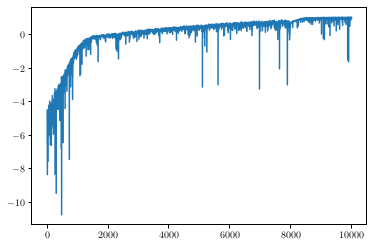

In [ ]:
plt.plot(elbo_history[10000:])

In [ ]:
fsigma_f, fell, fsigma_n, fz_fracs, fv_vector, fl_diag, fl_odiag, ftrise, ftaudiff, flag = fparams

In [ ]:
ilag = ilag ** 2

ilag_d = ilag[:,None]

iz_vector = (0.5 * np.sin( np.pi * (iz_fracs - 0.5)) + 0.5) * (ftime[-1, 0] - ilag_d) + ilag_d

idz = np.asarray(Diag(np.exp(il_diag)))
il_matrix = idz.copy()
il_matrix[:, indices[0], indices[1]] = il_odiag


flag = flag ** 2

flag_d = flag[:, :, None] 

fz_vector = (0.5 * np.sin( np.pi * (fz_fracs - 0.5)) + 0.5) * (ftime[-1] - flag_d) + flag_d

fd = np.asarray(Diag(np.exp(fl_diag)))
fl_matrix = fd.copy()
fl_matrix[:, indices[0], indices[1]] = fl_odiag

In [ ]:
print(iz_vector.shape)

(130, 20, 1)


In [ ]:
print(fsigma_f)

[[ 3.27570253e-01]
 [ 6.86221190e-01]
 [ 8.33165080e-01]
 [ 8.62232256e-01]
 [ 2.37762797e-01]
 [ 2.65778481e-01]
 [ 9.29066337e-01]
 [ 1.28325715e-01]
 [ 8.30742663e-01]
 [ 8.25168546e-01]
 [ 3.50398291e-01]
 [ 1.00000000e+00]
 [ 1.00451528e+00]
 [ 3.81305226e-01]
 [ 1.44494094e-01]
 [ 1.63469266e-01]
 [ 8.96014191e-01]
 [ 7.28120011e-05]
 [ 6.84905230e-01]
 [ 1.30340607e+00]
 [ 8.06453325e-01]
 [ 6.70975223e-01]
 [ 8.19449822e-01]
 [ 2.37356562e-01]
 [ 3.21332713e-01]
 [ 1.00000000e+00]
 [ 4.45190330e-01]
 [ 9.28017375e-01]
 [ 1.19158690e+00]
 [ 8.69876273e-01]
 [ 8.10618655e-01]
 [ 8.73010120e-01]
 [ 1.02575646e+00]
 [ 6.73977428e-01]
 [ 8.32730951e-01]
 [ 8.84569295e-01]
 [ 1.03515100e+00]
 [ 1.28907959e+00]
 [ 1.83813699e+00]
 [ 6.74385727e-01]
 [ 9.11798323e-01]
 [ 8.69224156e-01]
 [ 8.92801843e-01]
 [ 1.32521355e-01]
 [ 1.08620859e+00]
 [ 4.52073111e-01]
 [ 4.65074304e-02]
 [ 9.13553445e-01]
 [ 1.59175524e-01]
 [ 8.75451095e-01]
 [ 1.98915029e+00]
 [ 8.99183006e-01]
 [ 2.6543315

In [ ]:
print(fell)

[[-0.32412516]
 [ 0.05961879]
 [ 0.06325685]
 [ 0.0632284 ]
 [-0.12535716]
 [ 0.06145301]
 [-0.12390791]
 [ 0.16708986]
 [-0.17485887]
 [-0.05828776]
 [-0.07795538]
 [ 0.002     ]
 [ 0.16105483]
 [ 0.25224859]
 [ 0.30795707]
 [-0.02350847]
 [ 0.06239817]
 [-0.12627106]
 [ 0.08131391]
 [ 0.13257275]
 [ 0.19744937]
 [ 0.26121043]
 [-0.05927847]
 [ 0.0494656 ]
 [ 0.04490722]
 [ 0.002     ]
 [ 0.25192467]
 [ 0.06321326]
 [ 0.11767493]
 [-0.12743269]
 [-0.06108346]
 [-0.05927918]
 [-0.22328928]
 [-0.05517648]
 [-0.05988578]
 [-0.05927414]
 [-0.1131457 ]
 [-0.10600683]
 [-0.13061913]
 [-0.30983117]
 [ 0.06323922]
 [-0.10035307]
 [ 0.06320103]
 [ 0.05451043]
 [ 0.20068007]
 [-0.2165915 ]
 [-0.26146002]
 [-0.05922053]
 [ 0.32566073]
 [-0.07095072]
 [-0.13117456]
 [-0.05934265]
 [ 0.16954529]
 [ 0.06323364]
 [-0.06034971]
 [ 0.13588003]
 [-0.27162085]
 [-0.06349232]
 [ 0.08868275]
 [-0.14947122]
 [ 0.002     ]
 [ 0.002     ]
 [ 0.06323418]
 [ 0.08919475]
 [ 0.0632068 ]
 [-0.14864658]
 [-0.15230

In [ ]:
print(fsigma_n)

0.06048589562086625


In [ ]:
print(ftrise)

[[ 2.12131524e-01]
 [ 3.61323104e-04]
 [ 5.37192594e-03]
 [ 2.84240331e-03]
 [ 2.94230181e-01]
 [ 4.18914853e-03]
 [ 3.66407167e-01]
 [ 1.04352896e-01]
 [ 4.31268435e-01]
 [ 5.09678761e-04]
 [ 3.17438843e-01]
 [ 2.23606798e-01]
 [ 3.06766318e-01]
 [ 2.28824585e-01]
 [ 1.13772931e-01]
 [ 1.44586455e-01]
 [-1.09944713e-03]
 [ 9.54752972e-04]
 [ 8.46672290e-04]
 [ 4.43161501e-01]
 [ 1.24283204e-01]
 [ 3.15645154e-01]
 [ 5.03448048e-03]
 [ 1.41464689e-01]
 [ 1.45075482e-01]
 [ 2.23606798e-01]
 [ 1.97302438e-01]
 [ 4.55353666e-04]
 [ 5.34423322e-01]
 [ 3.86103355e-01]
 [ 1.60977642e-03]
 [-8.36433234e-04]
 [ 4.11925691e-01]
 [ 2.96906535e-01]
 [ 2.39431147e-03]
 [ 2.47110897e-03]
 [ 9.47516894e-01]
 [ 3.87271106e-01]
 [ 3.80071739e-01]
 [ 3.59747769e-01]
 [ 3.43133107e-03]
 [ 2.99186056e-01]
 [ 5.13433195e-03]
 [ 1.31428053e-01]
 [ 3.32982028e-01]
 [ 2.17722792e-01]
 [ 8.32881446e-02]
 [ 5.25661271e-03]
 [ 1.70115983e-01]
 [-3.47733742e-03]
 [ 5.47412008e-01]
 [ 1.52960119e-03]
 [ 1.2344468

In [ ]:
print(ftaudiff)

[[ 5.76142832e-02]
 [ 1.99582600e-03]
 [-9.98423443e-11]
 [-1.24376696e-07]
 [ 2.26864106e-01]
 [-2.70865581e-28]
 [ 2.64787370e-01]
 [-1.14882051e-05]
 [ 2.59677538e-01]
 [-4.11032501e-03]
 [ 2.09881826e-01]
 [ 1.00000000e-01]
 [ 1.48840300e-01]
 [ 6.67843758e-02]
 [ 2.87004049e-05]
 [ 1.94522310e-04]
 [ 1.89716262e-03]
 [-3.40476857e-03]
 [-2.48590880e-03]
 [ 3.15523432e-01]
 [-6.80174334e-07]
 [ 1.66615913e-01]
 [ 5.00148231e-09]
 [ 5.36269961e-09]
 [ 5.04802940e-01]
 [ 1.00000000e-01]
 [ 3.37128129e-02]
 [-3.98857940e-09]
 [ 5.41105744e-01]
 [ 4.07442294e-01]
 [ 2.28759865e-09]
 [-2.83950597e-03]
 [ 2.64385027e-01]
 [ 1.20749160e-01]
 [ 7.74070618e-08]
 [ 3.63935852e-09]
 [ 8.51903553e-01]
 [ 2.35120733e-01]
 [ 2.16427099e-01]
 [ 1.99239100e-01]
 [ 5.23851990e-08]
 [ 1.32535110e-01]
 [ 7.46091423e-08]
 [-3.46125403e-07]
 [ 1.73497557e-01]
 [ 5.24992740e-02]
 [-6.53637989e-03]
 [-7.06027331e-10]
 [ 3.15225492e-03]
 [-2.52838104e-03]
 [ 4.86289836e-01]
 [ 1.88542444e-04]
 [ 7.7770920

In [ ]:
print(flag)

[[5.79805665e-02]
 [2.86554397e-03]
 [2.03315081e-03]
 [1.20168406e-03]
 [4.09574556e-10]
 [7.37205729e-03]
 [1.07820169e-02]
 [1.32868674e-02]
 [8.37575203e-02]
 [1.80287716e-02]
 [5.10778347e-02]
 [1.00000000e-02]
 [1.68535901e-02]
 [2.85339639e-11]
 [1.43199876e-12]
 [2.44836054e-03]
 [4.19307122e-04]
 [9.54273115e-03]
 [1.71227455e-03]
 [4.92094434e-02]
 [1.63296039e-14]
 [3.65657900e-02]
 [1.32824845e-09]
 [4.02345666e-02]
 [9.79595709e-02]
 [1.00000000e-02]
 [3.63022715e-02]
 [1.43070052e-03]
 [1.02065046e-09]
 [3.81177991e-15]
 [3.63548809e-02]
 [2.06204436e-02]
 [1.35314064e-01]
 [6.55307396e-02]
 [1.80050962e-02]
 [2.94606186e-02]
 [1.28361540e-01]
 [9.40555550e-02]
 [4.95993415e-02]
 [4.45835261e-03]
 [3.21711818e-02]
 [3.92007233e-02]
 [2.07511573e-03]
 [1.32425665e-02]
 [4.40997545e-02]
 [5.25500931e-02]
 [4.77227450e-02]
 [2.80132676e-02]
 [3.64975979e-02]
 [2.63801526e-02]
 [5.05306545e-10]
 [3.01854909e-02]
 [1.88288236e-02]
 [2.06599756e-03]
 [2.41692544e-02]
 [6.784367

## Variational Predictions

In [ ]:
fpred_points = ftimet.copy()
ytime = ytime.reshape((k + 1, 1))

In [ ]:
isigma_f = isigma_f.reshape(num_filt, 1, 1)
iell = iell.reshape(num_filt, 1, 1)
itrise = itrise.reshape(num_filt, 1, 1)
itaudiff = itaudiff.reshape(num_filt, 1, 1)
ilag = ilag.reshape(num_filt, 1, 1)

fsigma_f = fsigma_f.reshape(num_filt, 1, 1)
fell = fell.reshape(num_filt, 1, 1)
ftrise = ftrise.reshape(num_filt, 1, 1)
ftaudiff = ftaudiff.reshape(num_filt, 1, 1)
flag = flag.reshape(num_filt, 1, 1)

In [ ]:
print(iz_vector.shape)

(130, 20, 1)


In [ ]:
ikmm = Squared_exp(iz_vector, iz_vector.transpose(0, 2, 1), isigma_f, iell)
icpred = np.linalg.cholesky(ikmm + 1e-6 * np.eye(num_ind))
ikzast = Squared_exp(iz_vector, fpred_points.T, isigma_f, iell)
ibzast = np.zeros((num_filt, num_ind, n + 1))
for i in range(num_filt):
  ibzast[i] = sc.linalg.solve_triangular(icpred[i], ikzast[i], lower = True)
ibzastT = ibzast.transpose(0, 2, 1)
ipredenv = AlpEnvelope(fpred_points, itrise, itaudiff, ilag)
ipredenvT = ipredenv.transpose(0, 2, 1)
imeanpred = ipredenv * (ibzastT @ iv_vector)

ikastast = Squared_exp(fpred_points, fpred_points.T, isigma_f, iell)
icovpred = ipredenv * (ikastast + ibzastT @ (il_matrix @ il_matrix.transpose(0, 2, 1) - np.eye(num_ind)) @ ibzast) * ipredenvT

In [ ]:
fkmm = Squared_exp(fz_vector, fz_vector.transpose(0, 2 ,1), fsigma_f, fell)
fcpred = np.linalg.cholesky(fkmm + 1e-6 * np.eye(num_ind))
fkzast = Squared_exp(fz_vector, fpred_points.T, fsigma_f, fell)
fbzast = np.zeros((num_filt, num_ind, n + 1))
for i in range(num_filt):
  fbzast[i] = sc.linalg.solve_triangular(fcpred[i], fkzast[i], lower = True)
fbzastT = fbzast.transpose(0, 2, 1)
fpredenv = AlpEnvelope(fpred_points, ftrise, ftaudiff, flag)
fpredenvT = fpredenv.transpose(0, 2, 1)
fmeanpred = fpredenv * (fbzastT @ fv_vector)

fkastast = Squared_exp(fpred_points, fpred_points.T, fsigma_f, fell)
fcovpred = fpredenv * (fkastast + fbzastT @ (fl_matrix @ fl_matrix.transpose(0, 2, 1) - np.eye(num_ind)) @ fbzast) * fpredenvT

In [ ]:
print(imeanpred.shape)

(130, 1001, 1)


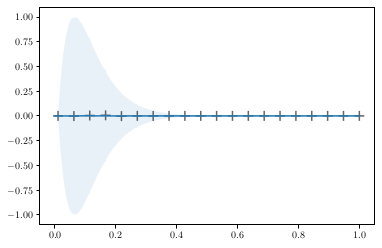

In [ ]:
ipredindenv = AlpEnvelope(iz_vector, itrise, itaudiff, ilag)
index = 2
plt.plot(fpred_points, imeanpred[index])
is2 = np.sqrt(np.diag(icovpred[index]))
ifill = (imeanpred[index].flatten() - is2, imeanpred[index].flatten() + is2)
plt.fill_between(fpred_points.flatten(), *ifill, alpha = 0.1)
plt.scatter(iz_vector[index], (ipredindenv * (icpred @ iv_vector))[index], s = 100, marker = '+', c='k', alpha = 0.6)
#plt.xlim([ftime[0], ftime[-1]])

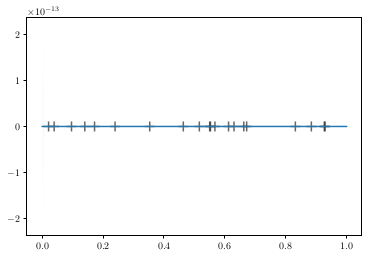

In [ ]:
predindenv = AlpEnvelope(fz_vector, ftrise, ftaudiff, flag)

plt.plot(fpred_points, fmeanpred[index])
s2 = np.sqrt(np.diag(fcovpred[index]))
fill = (fmeanpred[index].flatten() - s2, fmeanpred[index].flatten() + s2)
plt.fill_between(fpred_points.flatten(), *fill, alpha = 0.1)
plt.scatter(fz_vector[index], (predindenv * (fcpred @ fv_vector))[index], s = 100, marker = '+', c='k', alpha = 0.6)
#plt.xlim([ftime[0], ftime[-1]])

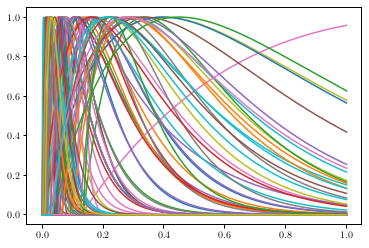

In [ ]:
envelopes = AlpEnvelope(ftime, ftrise, ftaudiff, flag)
for i in envelopes:
  plt.plot(ftime, i)

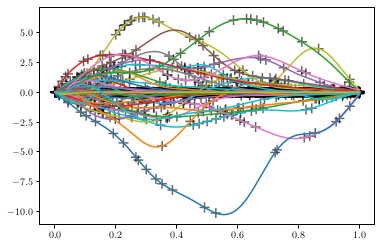

In [ ]:
for index in range(num_filt):
  plt.plot(fpred_points, fmeanpred[index])
  s2 = np.sqrt(np.diag(fcovpred[index]))
  fill = (fmeanpred[index].flatten() - s2, fmeanpred[index].flatten() + s2)
  plt.fill_between(fpred_points.flatten(), *fill, alpha = 0.1)
  plt.scatter(fz_vector[index], (predindenv * (fcpred @ fv_vector))[index], s = 100, marker = '+', c='k', alpha = 0.6)
  #plt.xlim([ftime[0], ftime[-1]])

In [ ]:
print(xtest.shape)

(130, 6000, 1)


In [ ]:
def OUTconvolve(Filters, N, K, X_fft):
  Pad = np.hstack((Filters, np.zeros((num_filt, K, 1))))
  Pred_fft = np.fft.rfft(Pad, axis = -2)
  Pred_sum = np.sum(Pred_fft * X_fft, axis = 0)
  Pred_fitfft = np.fft.irfft(Pred_sum, N + K + 1, axis = -2)[ : K + 1]
  return Pred_fitfft


In [ ]:
is2 = np.sqrt(np.diagonal(icovpred, axis1=1, axis2=2)).reshape((num_filt, n + 1, 1))

imeanpredict = OUTconvolve(imeanpred, n, k, x_fft)
imeanpredictns2 = OUTconvolve(imeanpred - 2 * is2, n, k, x_fft)
imeanpredictps2 = OUTconvolve(imeanpred + 2 * is2, n, k, x_fft)

In [ ]:
fs2 = np.sqrt(np.diagonal(fcovpred, axis1=1, axis2=2)).reshape((num_filt, n + 1, 1))

fmeanpredict = OUTconvolve(fmeanpred, n, k, x_fft)
fmeanpredictns2 = OUTconvolve(fmeanpred - 2 * fs2, n, k, x_fft)
fmeanpredictps2 = OUTconvolve(fmeanpred + 2 * fs2, n, k, x_fft)

In [ ]:
fpad = np.hstack((fmeanpred, np.zeros((num_filt, k, 1))))
fpred_fft = np.fft.rfft(fpad, axis = -2)
fpred_fitfft = np.fft.irfft(fpred_fft * x_fft, n + k + 1, axis = -2)[:, : k + 1]
fmeanpredict = np.sum(fpred_fitfft, axis=0)

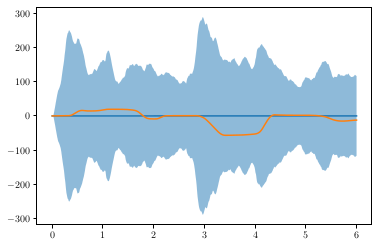

In [ ]:
plt.plot(ytime, imeanpredict)
plt.plot(ytime, ytest.reshape((k + 1, 1)))
plt.fill_between(ytime.flatten(), imeanpredictns2.flatten() - 2 * isigma_n,  
                  imeanpredictps2.flatten() + 2 * isigma_n, alpha = 0.5)

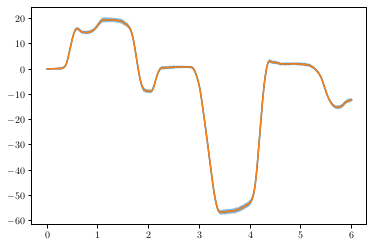

In [ ]:
plt.plot(ytime, fmeanpredict)
plt.plot(ytime, ytest.reshape((k + 1, 1)))
plt.fill_between(ytime.flatten(), fmeanpredictns2.flatten() - 2 * fsigma_n,  
                  fmeanpredictps2.flatten() + 2 * fsigma_n, alpha = 0.5)

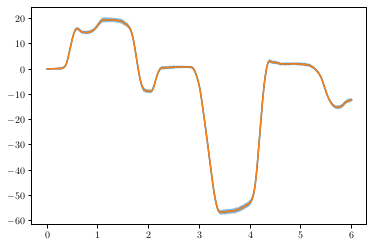

In [ ]:
ytesttru = ytest[:20000]
ytimetru = ytime[:20000]
fmeanpredicttru = fmeanpredict[:20000]
fmeanpredictns2tru = fmeanpredictns2[:20000]
fmeanpredictps2tru = fmeanpredictps2[:20000]
plt.plot(ytimetru, fmeanpredicttru)
plt.plot(ytimetru, ytesttru)
plt.fill_between(ytimetru.flatten(), fmeanpredictns2tru.flatten() - 2 * fsigma_n,  
                  fmeanpredictps2tru.flatten() + 2 * fsigma_n, alpha = 0.5)

## Testing Against New Data

In [ ]:
kext = 100000
data = pd.read_hdf('./Data/Allfinger_posdata.h5')
xnew = data.spikes.to_numpy()[:kext, :num_filt]
ytimenew = (data.index / np.timedelta64(1, 's')).to_numpy()[:kext]
ycoordnew = data.finger_pos.y.to_numpy()[:kext]
xcoordnew = data.finger_pos.x.to_numpy()[:kext]
ytestnew = ycoordnew.reshape(ycoordnew.shape[0], 1)
xnewtes = xnew.T[:, :, None]

ytestnew -= ytestnew[0, 0]
xnew = xnew.T[:,:,None]
print(np.where(xtest != xnewtes[:, :k + 1]))
print(xnew.shape)

(array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))
(130, 100000, 1)


In [ ]:
print(np.isnan(ycoordnew).any())

False


In [ ]:
ktotal = xnew.shape[1] - 1

In [ ]:
xnewpad = np.hstack((xnew, np.zeros((num_filt, ktotal, 1))))
xnewfft = np.fft.rfft(xnewpad, n + ktotal + 1, axis = 1)[:, :ktotal + 1]
fnew = OUTconvolve(fmeanpred, n, ktotal, xnewfft)
fnewns2 = OUTconvolve(fmeanpred - 2 * fs2, n, ktotal, xnewfft)
fnewps2 = OUTconvolve(fmeanpred + 2 * fs2, n, ktotal, xnewfft)

In [ ]:
print(fnew.shape)
print(fnewns2.shape)
print(ytestnew.shape)
ytimenew = ytimenew.reshape(ytimenew.shape[0], 1)
print(ytimenew.shape)

(100000, 1)
(100000, 1)
(100000, 1)
(100000, 1)


In [ ]:
print(ytimenew[0])

[1.352]


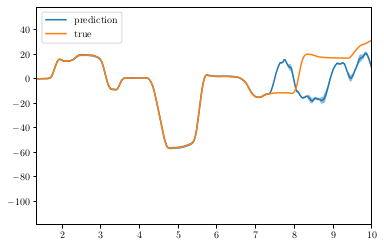

In [ ]:
plt.plot(ytimenew, fnew, label = 'prediction')
plt.fill_between(ytimenew.flatten(), fnewns2.flatten() - 2 * fsigma_n,  
                  fnewps2.flatten() + 2 * fsigma_n, alpha = 0.5)
plt.plot(ytimenew, ytestnew, label = 'true')

plt.xlim([ytimenew[0], 10.0])
plt.legend()

## $R^2$ Value

### On training data

In [ ]:
datmean = np.mean(ytest)
ess = np.sum((fmeanpredict - ytest)**2)
tss = np.sum((ytest - datmean)**2)
r2train = 1 - ess/tss

In [ ]:
print(r2train)

0.9999972309990002


#### On test data

In [ ]:
obsmean = np.mean(ytestnew)
ssres = np.sum(np.square(ytestnew - fnew))
sstot = np.sum(np.square(ytestnew - obsmean))
r2testa = 1 - ssres/sstot
print(r2testa)

-0.5482391112809946


## Fixing Convolution

In [ ]:
%%capture
fmeanpred # the filter for each spike train
xtest # the original spike data

### One spike train

#### Numpy convolution

In [ ]:
indy = 20 # index of train checking
outindy = np.convolve(xtest[indy].flatten(), fmeanpred[indy].flatten())[:k + 1]

In [ ]:
convolutions = np.zeros((num_filt, k + 1))
for i in range(num_filt):
  convolutions[i] = np.convolve(xtest[i].flatten(), fmeanpred[i].flatten())[:k + 1]
prediction = np.sum(convolutions, axis=0)
print(np.shape(prediction))

(6000,)


In [ ]:
print(np.equal(fullindy, prediction))

NameError: name 'fullindy' is not defined

#### FFT convolution

In [ ]:
xindypad = np.vstack((xtest[indy], np.zeros((n, 1))))
xindyfft = np.fft.rfft(xindypad, axis = 0)

findypad = np.vstack((fmeanpred[indy], np.zeros((k, 1))))
findyfft = np.fft.rfft(findypad, axis = 0)
outfftindy = np.fft.irfft(xindyfft * findyfft, n + k + 1, axis = 0)[:k + 1]

(3.0, 5.0)

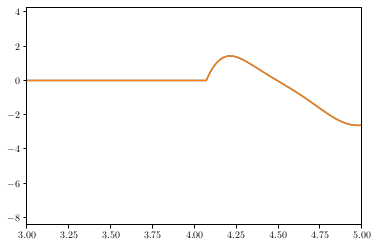

In [ ]:
plt.plot(ytime, outindy)
plt.plot(ytime, outfftindy)
plt.xlim([3.0, 5.0])

In [ ]:
fullindy = np.zeros(k + 1)
fftindy = np.zeros(k + 1)
for i in range(num_filt):
  fullindy += np.convolve(xtest[i].flatten(), fmeanpred[i].flatten())[:k + 1] # np convolution

  xindypad = np.vstack((xtest[i], np.zeros((n, 1))))
  xindyfft = np.fft.rfft(xindypad, axis = 0)

  findypad = np.vstack((fmeanpred[i], np.zeros((k, 1))))
  findyfft = np.fft.rfft(findypad, axis = 0)
  fftindy += np.fft.irfft(xindyfft * findyfft, n + k + 1, axis = 0).flatten()[:k + 1]

(0.0, 10.0)

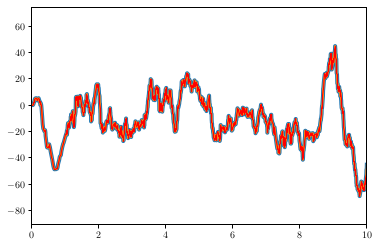

In [ ]:
plt.plot(ytime, fullindy, linewidth = 4.0)
plt.plot(ytime, fftindy, linewidth = 2.0)
plt.plot(ytime, prediction, linewidth = 0.5, color = 'red')
plt.xlim([0.0, 10.0])